# Analyzing SASUMO outputs

### Import the Required Libraries

In [1]:
import os
import sys
import pathlib

In [2]:
def find_root(path):
    if os.path.split(path)[-1] != "airport-harper-sumo":
        return find_root(os.path.split(path)[0])
    return path


In [3]:
import pathlib

PATH = find_root(pathlib.Path().absolute())
if PATH not in sys.path:
    print(f"adding {PATH} to path")
    sys.path.append(PATH)


adding /home/max/Development/airport-harper-sumo to path


In [4]:
import json5 as json
import sys

import numpy as np
import pandas as pd
import pint
import plotly.graph_objects as go

from SALib.analyze import sobol
# from SASUMO.params import SASUMOConf, ReplayProcessConf

In [5]:
ureg = pint.UnitRegistry()


## Defining the Analysis Root

In [6]:
ROOT = r"/Users/max/tmp/Random_Seed+Deterministic_Route+Time_Gap+All_Dev+Uniform+LCParam+2_Hours/"
TOP_LEVEL_SETTINGS = os.path.join(ROOT, "sasumo_params.yaml")
OUTPUT = os.path.join(ROOT, "output.txt")
PROBLEM = os.path.join(ROOT, "SALib_Problem.json")


In [7]:
# with open(TOP_LEVEL_SETTINGS, 'rb') as f:
# settings = SASUMOConf(os.path.join(ROOT, "sasumo_params.yaml"))


## Open up the Problem

In [7]:
with open(PROBLEM, "r") as f:
    problem = json.load(f)
problem


{'num_vars': 13,
 'names': ['RandomSeed',
  'Tau',
  'TauDev',
  'Accel',
  'AccelDev',
  'Decel',
  'DecelDev',
  'minGap',
  'minGapDev',
  'speedFactor',
  'speedDeviation',
  'junctionTimeGap',
  'lcKeepRight'],
 'bounds': [[1, 1000000],
  [0.2, 3],
  [1.014, 2.028],
  [1, 6],
  [0.555, 6.8576],
  [1, 8],
  [1.5766, 3.1532],
  [0.1, 6],
  [2.304, 4.608],
  [0.8, 1.3],
  [0.05, 0.3],
  [2, 7],
  [1, 5]]}

## Creating a table of the Results and Parameters

In [8]:
def gen_import_func():

    from SASUMO.functions.free_flow_speed import FreeFlowSpeed
    from SASUMO.functions.simulation_metrics import SimulationMetrics
    from SASUMO.functions.per_phase_delay import E3SimulationMetrics
    from SASUMO.params import SASUMOConf
    from tools.output_tools import USDOTCalibration
    

    def import_data(
        _dir_name,
        _dir,
    ):
        try:
            with open(os.path.join(_dir, "f_out.txt"), "r") as f:
                d = {"f_out": float(f.read()), "sample_num": int(_dir_name)}
        except Exception as e:
            raise f"issue with {_dir}" from e

        d |= {
            # load the variable values
            **SASUMOConf.var_2_records(os.path.join(_dir, "params.yaml")),
            # load the calibration data
            **USDOTCalibration.load_calibration_data(os.path.join(_dir, "calibration_results.json"), load_all=True),
            # load the simulation metrics
            **SimulationMetrics.load_traffic_metrics(os.path.join(_dir, "simulation_metrics.json")),
            # load the simulation speed
            **FreeFlowSpeed.speed_analysis_loader(os.path.join(_dir, "speed_analysis.json")),
            # load the per-phase
            **E3SimulationMetrics.load_traffic_metrics(os.path.join(_dir, "per_phase_delay.json"))
        }

        return d
    
    return import_data


In [9]:
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    
    from tools.output_tools import FuelProperties

    df["Fuel_Gal"] = FuelProperties.joule_2_gal_gas(
        df["f_out"].values * 1e6
    )  # this value is in MJ

    for key in CAL_KEYS:
        if "63082004-EB" not in key:
            res = 0.95 - df[key] if "1.96" in key else 0.666 - df[key]
            res[res < 0] = 0
            df[f"{key}_score"] = 1 - res
        else:
            df[f"{key}_score"] = 1
    
    df["cal_score"] = df[[f"{key}_score" for key in CAL_KEYS]].mean(axis=1)
    # df.drop([f"{key}_score" for key in CAL_KEYS], inplace=True, axis=1)
    return df


In [58]:
FORCE_RECOMPUTE = False
CAL_KEYS = [
            "_".join([key, movement, sigma])
            for key in ["63082002", "63082003", "63082004"]
            for movement in ["WB", "EB"]
            for sigma in ["sigma_1", "sigma_1.96"]
        ]

if FORCE_RECOMPUTE or not os.path.exists(os.path.join(ROOT, "processed_results.csv")):
    print("Processing the SA runs")
    
    from joblib import Parallel, delayed
    

    results = Parallel(n_jobs=os.cpu_count() - 1)(
        delayed(gen_import_func())(
            dir.name,
            dir.path,
        )
        for dir in os.scandir(ROOT)
        if dir.is_dir()
    )
    results_df = pd.DataFrame.from_records(results, index="sample_num").sort_index()
    results_df = prepare_df(results_df)
    print(f"Saving processed csv to {os.path.join(ROOT, 'processed_results.csv')}")
    results_df.to_csv(os.path.join(ROOT, "processed_results.csv"))

else:
    print("reading from csv")
    results_df = pd.read_csv(os.path.join(ROOT, "processed_results.csv"))


reading from csv


In [59]:
results_df['Fuel_L'] = results_df['Fuel_Gal'] * 3.78541178

In [60]:

results_df.tail()


sample_num         f_out  RandomSeed       Tau    TauDev     Accel  \
7163        7163  11837.706319      943359  0.533594  1.669535  3.802734   
7164        7164  12835.957134      943359  0.533594  1.669535  3.802734   
7165        7165  12825.292460      943359  0.533594  1.669535  3.802734   
7166        7166  12788.806348      943359  0.533594  1.669535  3.802734   
7167        7167  12808.019048      943359  0.533594  1.669535  3.802734   

      AccelDev     Decel  DecelDev    minGap  minGapDev  speedFactor  \
7163  2.167579  7.330078  1.782913  4.006445     4.1085     0.900586   
7164  2.167579  7.330078  1.782913  4.006445     4.1085     1.123242   
7165  2.167579  7.330078  1.782913  4.006445     4.1085     1.123242   
7166  2.167579  7.330078  1.782913  4.006445     4.1085     1.123242   
7167  2.167579  7.330078  1.782913  4.006445     4.1085     1.123242   

      speedDeviation  junctionTimeGap  lcKeepRight  63082002_4_sigma_1.96  \
7163        0.258496         4.802734     1.039062                    1.0   
7164        0.135449         4.802734     1.039062                    1.0   
7165        0.258496         6.150391     1.039062                    1.0   
7166        0.258496         4.802734     1.242188                    1.0   
7167        0.258496         4.802734     1.039062                    1.0   

      63082002_4_sigma_1  63082002_4_BDAE  63082002_4_BDSE  \
7163                 1.0             True             True   
7164                 1.0             True             True   
7165                 1.0             True             True   
7166                 1.0             True             True   
7167                 1.0             True             True   

      63082002_5_sigma_1.96  63082002_5_sigma_1  63082002_5_BDAE  \
7163                    1.0                 1.0             True   
7164                    1.0                 1.0             True   
7165                    1.0                 1.0             True   
7166                    1.0                 1.0             True   
7167                    1.0                 1.0             True   

      63082002_5_BDSE  63082002_9_sigma_1.96  63082002_9_sigma_1  \
7163             True                    0.0                 0.0   
7164             True                    0.0                 0.0   
7165             True                    0.0                 0.0   
7166             True                    0.0                 0.0   
7167             True                    0.0                 0.0   

      63082002_9_BDAE  63082002_9_BDSE  63082002_10_sigma_1.96  \
7163            False            False                0.470588   
7164            False            False                0.823529   
7165            False            False                0.823529   
7166            False            False                0.823529   
7167            False            False                0.823529   

      63082002_10_sigma_1  63082002_10_BDAE  63082002_10_BDSE  \
7163             0.000000              True             False   
7164             0.235294              True             False   
7165             0.294118              True             False   
7166             0.294118              True             False   
7167             0.294118              True             False   

      63082002_11_sigma_1.96  63082002_11_sigma_1  63082002_11_BDAE  \
7163                0.058824                  0.0              True   
7164                0.058824                  0.0              True   
7165                0.058824                  0.0              True   
7166                0.058824                  0.0              True   
7167                0.058824                  0.0              True   

      63082002_11_BDSE  63082002_12_sigma_1.96  63082002_12_sigma_1  \
7163             False                0.823529             0.411765   
7164             False                0.882353             0.529412   
7165             False            

In [63]:
results_df['cal_score_2'] = results_df[CAL_KEYS].sum(axis=1)

### Calculating Watiting Time Ratio

In [95]:
import itertools

MAINLINE_PHASES = ["1", "2", "5", "6"]
SIDE_PHASES = ["3", "4", "7", "8"]

TL = ["63082002", "63082003", "63082004"]

MAINLINE_SUMBOIS = [f"{tl}_{p}_totalTimeLoss" for tl, p in itertools.product(TL, MAINLINE_PHASES) if tl != "63082002" and p not in ["1", "3", "7", "8"]]
SIDESTREET_SUMBOIS = [f"{tl}_{p}_totalTimeLoss" for tl, p in itertools.product(TL, SIDE_PHASES)if tl != "63082002" and p not in ["1", "3", "7", "8"]]


In [98]:

results_df['mainline_timeloss'] = results_df[MAINLINE_SUMBOIS].sum(axis=1)
results_df['sidestreet_timeloss'] = results_df[SIDESTREET_SUMBOIS].sum(axis=1)
results_df['timeloss_ratio'] = results_df['sidestreet_timeloss'] / (results_df['mainline_timeloss'] + results_df['sidestreet_timeloss'])

In [101]:
import plotly.figure_factory as ff


fig = ff.create_distplot(
    [
        results_df['timeloss_ratio']
        # results_df.loc[results_df["cal_score"] >= 1, "Fuel_Gal"],
    ],
    group_labels=["Ratio of Timeloss"],
    bin_size=0.005,
)
fig.show()


## Plotting Calibration   

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df.index, y=results_df["cal_score_2"], mode="lines"))
fig.update_layout(
    yaxis=dict(title="Calibration Score"),
    xaxis=dict(title="Sample Number"),
)
fig.show()


In [15]:
results_df.sort_values(
    "cal_score",
)[CAL_KEYS + ['Accel', 'Tau', ]].head()


63082002_WB_sigma_1  63082002_WB_sigma_1.96  63082002_EB_sigma_1  \
828                   1.0                     1.0                  1.0   
3997                  1.0                     1.0                  1.0   
4012                  1.0                     1.0                  1.0   
2102                  1.0                     1.0                  1.0   
7031                  1.0                     1.0                  1.0   

      63082002_EB_sigma_1.96  63082003_WB_sigma_1  63082003_WB_sigma_1.96  \
828                      1.0                  1.0                     1.0   
3997                     1.0                  1.0                     1.0   
4012                     1.0                  1.0                     1.0   
2102                     1.0                  1.0                     1.0   
7031                     1.0                  1.0                     1.0   

      63082003_EB_sigma_1  63082003_EB_sigma_1.96  63082004_WB_sigma_1  \
828              0.941176                0.941176                  1.0   
3997             0.941176                0.941176                  1.0   
4012             0.882353                1.000000                  1.0   
2102             1.000000                1.000000                  1.0   
7031             1.000000                1.000000                  1.0   

      63082004_WB_sigma_1.96  63082004_EB_sigma_1  63082004_EB_sigma_1.96  \
828                      1.0             0.823529                0.882353   
3997                     1.0             0.823529                0.882353   
4012                     1.0             0.823529                0.882353   
2102                     1.0             0.882353                0.882353   
7031                     1.0             0.882353                0.882353   

         Accel       Tau  
828   1.322266  2.775781  
3997  1.185547  2.874219  
4012  1.830078  2.589844  
2102  1.888672  2.622656  
7031  2.103516  2.655469

## Display the top Fuel Consumers

In [16]:
results_df.sort_values("f_out", ascending=False)

sample_num         f_out  RandomSeed       Tau    TauDev     Accel  \
3997        3997  16312.019034      638672  2.874219  1.724988  1.185547   
2899        2899  16208.208317      283203  2.972656  1.641809  1.126953   
5688        5688  15454.693712      455078  2.611719  1.031824  1.224609   
5685        5685  15445.334709       21485  2.611719  1.031824  1.556641   
5689        5689  15440.249067      455078  2.611719  1.031824  1.556641   
...          ...           ...         ...       ...       ...       ...   
2643        2643  10919.752179      560547  0.391406  1.107082  5.482422   
5066        5066  10917.203054      279297  0.905469  1.107082  5.951172   
2633        2633  10913.055777      423828  0.391406  1.107082  5.482422   
6784        6784  10908.412692      814453  0.730469  1.744793  4.916016   
5063        5063  10858.110344      279297  0.905469  1.107082  5.951172   

      AccelDev     Decel  DecelDev    minGap  ...  \
3997  0.739646  5.197266  2.953046  4.259961  ...   
2899  2.586111  6.537109  3.094693  5.873242  ...   
5688  2.684589  6.810547  2.528103  5.320117  ...   
5685  2.684589  6.810547  2.528103  5.320117  ...   
5689  1.872145  6.810547  2.528103  5.320117  ...   
...        ...       ...       ...       ...  ...   
2643  1.182798  1.916016  1.869133  2.439258  ...   
5066  0.641168  1.369141  1.992305  5.619727  ...   
2633  1.182798  1.916016  1.869133  2.439258  ...   
6784  1.601330  1.451172  1.862975  1.425195  ...   
5063  0.641168  1.369141  1.992305  5.619727  ...   

      63082002_EB_sigma_1.96_score  63082003_WB_sigma_1_score  \
3997                           1.0                        1.0   
2899                           1.0                        1.0   
5688                           1.0                        1.0   
5685                           1.0                        1.0   
5689                           1.0                        1.0   
...                            ...                        ...   
2643                           1.0                        1.0   
5066                           1.0                        1.0   
2633                           1.0                        1.0   
6784                           1.0                        1.0   
5063                           1.0                        1.0   

      63082003_WB_sigma_1.96_score  63082003_EB_sigma_1_score  \
3997                           1.0                        1.0   
2899                           1.0                        1.0   
5688                           1.0                        1.0   
5685                           1.0                        1.0   
5689                           1.0                        1.0   
...                            ...                        ...   
2643                           1.0                        1.0   
5066                           1.0                        1.0   
2633                           1.0                        1.0   
6784                           1.0                        1.0   
5063                           1.0                        1.0   

      63082003_EB_sigma_1.96_score  63082004_WB_sigma_1_score  \
3997                      0.991176                        1.0   
2899                      0.991176                        1.0   
5688                      1.000000                        1.0   
5685                      1.000000                        1.0   
5689                      1.000000                        1.0   
...                            ...                        ...   
2643                      1.000000                        1.0   
5066                      1.000000                        1.0   
2633                      1.000000                        1.0   
6784                      1.000000                        1.0   
5063                      1.000000                        1.0   

      63082004_WB_sigma_1.96_score  63082004_EB_sigma_1_score  \
3997                           1.0              

In [18]:
import plotly.figure_factory as ff


fig = ff.create_distplot(
    [
        results_df["Fuel_Gal"],
        results_df.loc[results_df["cal_score"] >= 1, "Fuel_Gal"],
    ],
    group_labels=["Fuel", "Calibrated Fuel"],
    bin_size=0.5,
)
fig.show()


In [102]:
import plotly.express as px
from plotly.subplots import make_subplots

def myround(x, base=5):
    return base * round(x/base)

px_fig = px.ecdf(results_df, x="Fuel_Gal", markers=True, lines=False, marginal="histogram", )
# fig.add_trace(
#     px.ecdf(results_df.loc[results_df["cal_score"] >= 1], x="Fuel_Gal", markers=True, lines=False, marginal="histogram", ).data[0]
# )

fig = make_subplots(rows=2, cols=2, start_cell="bottom-left")

for i, (p_name, name) in enumerate([("Fuel [L]", "Fuel_L", ), ("Average Delay [s]", "all_delay_average"), ("Average Travel Time [s]", "all_travel_time_average"), ("Timeloss Ratio [%]", "timeloss_ratio")]):
    px_fig = px.ecdf(results_df, x=name, markers=True, lines=False, marginal="histogram", )
    trace = px_fig.data[0]
    trace.marker.color = "black"
    # trace.update(
    #     xaxis=dict(title=p_name),
    # )
    fig.add_trace(trace, row=i // 2 + 1, col= i % 2 + 1)
    dtick = myround((results_df[name].max() - results_df[name].min()) / 5)
    _range = [results_df[name].min() - dtick / 2, results_df[name].max() + dtick / 2]
    fig.update_layout(**{("xaxis" if i < 1 else f"xaxis{i+1}"): dict(title=p_name, range=_range,  dtick=dtick)},)

fig.update_layout(
        template="simple_white",
        font_family="helvetica",
        font_size=20,
        height=600,
        width=800,
        # legend=dict(yanchor="top", y=1.0, xanchor="right", x=1, orientation="h"),
        # yaxis=dict(showgrid=True, range=[0, 2000] if not secondary else [0, 250]),
        # xaxis=dict(title="Fuel (gal)",)   # showgrid=True, range=[0, 20]),
    )

fig.show()

In [72]:
trace

Scattergl({
    'hovertemplate': 'all_delay_average=%{x}<br>probability=%{y}<extra></extra>',
    'legendgroup': '',
    'line': {'dash': 'solid', 'shape': 'hv'},
    'marker': {'color': 'black', 'symbol': 'circle'},
    'mode': 'markers',
    'name': '',
    'showlegend': False,
    'x': array([ 21.45387511,  21.51641411,  21.63087486, ...,  84.82056703,
                 96.58016215, 101.24914653]),
    'xaxis': 'x',
    'y': array([1.39508929e-04, 2.79017857e-04, 4.18526786e-04, ..., 9.99720982e-01,
                9.99860491e-01, 1.00000000e+00]),
    'yaxis': 'y'
})

In [24]:
import plotly.figure_factory as ff


fig = ff.create_distplot(
    [
        # results_df[columns.EB_fuel_energy_total] / results_df[columns.east_dep_mean],
        results_df["all_travel_time_average"], # * 2.2,
        results_df.loc[results_df["cal_score"] >= 1, "all_travel_time_average"] #* 2.2,

        # results_df.loc[results_df["cal_score"] >= 1, columns.EB_fuel_energy_total] / results_df.loc[results_df["cal_score"] >= 1, columns.all_fuel_energy_total],
    ],
    group_labels=["Average Travel Time", "Calibrated Average Travel Time"],
    bin_size=0.5,
)
fig.show()

In [23]:
pd.set_option('display.max_columns', len(results_df.columns))
results_df.loc[results_df["cal_score"] >= 1].sort_values("f_out", ascending=False)


sample_num         f_out  RandomSeed       Tau    TauDev     Accel  \
5687        5687  14764.578869      455078  2.611719  1.336816  1.556641   
2892        2892  14616.800025      169922  2.972656  1.693301  1.966797   
6828        6828  14458.817242      630859  2.108594  1.732910  2.240234   
975          975  14458.100698      931640  2.294531  1.507137  1.087891   
1822        1822  14453.334364      529297  2.447656  2.026020  1.576172   
...          ...           ...         ...       ...       ...       ...   
2643        2643  10919.752179      560547  0.391406  1.107082  5.482422   
5066        5066  10917.203054      279297  0.905469  1.107082  5.951172   
2633        2633  10913.055777      423828  0.391406  1.107082  5.482422   
6784        6784  10908.412692      814453  0.730469  1.744793  4.916016   
5063        5063  10858.110344      279297  0.905469  1.107082  5.951172   

      AccelDev     Decel  DecelDev    minGap  minGapDev  speedFactor  \
5687  2.684589  6.810547  2.528103  5.320117     3.1365     1.158398   
2892  3.053882  7.275391  2.534261  5.873242     3.8475     1.101758   
6828  3.349317  7.767578  2.078525  4.375195     3.1005     1.279492   
975   2.930785  7.576172  2.589689  5.550586     4.1535     1.121289   
1822  6.106704  7.384766  2.312552  5.573633     3.3795     1.281445   
...        ...       ...       ...       ...        ...          ...   
2643  1.182798  1.916016  1.869133  2.439258     3.1635     1.015820   
5066  0.641168  1.369141  1.992305  5.619727     4.1265     0.978711   
2633  1.182798  1.916016  1.869133  2.439258     3.1635     1.015820   
6784  1.601330  1.451172  1.862975  1.425195     3.8205     0.931836   
5063  0.641168  1.369141  1.992305  5.619727     4.1265     0.920117   

      speedDeviation  junctionTimeGap  lcKeepRight  63082002_4_sigma_1.96  \
5687        0.248730         2.791016     3.804688                    1.0   
2892        0.114941         2.341797     3.101562                    1.0   
6828        0.057324         2.615234     4.789062                    1.0   
975         0.152051         4.314453     1.679688                    1.0   
1822        0.056348         3.357422     4.289062                    1.0   
...              ...              ...          ...                    ...   
2643        0.173535         2.576172     1.664062                    1.0   
5066        0.237012         6.794922     2.273438                    1.0   
2633        0.064160         2.576172     1.664062                    1.0   
6784        0.182324         2.712891     1.492188                    1.0   
5063        0.237012         6.794922     3.195312                    1.0   

      63082002_4_sigma_1  63082002_4_BDAE  63082002_4_BDSE  \
5687                 1.0             True             True   
2892                 1.0             True             True   
6828                 1.0             True             True   
975                  1.0             True             True   
1822                 1.0             True             True   
...                  ...              ...              ...   
2643                 1.0             True             True   
5066                 1.0             True             True   
2633                 1.0             True             True   
6784                 1.0             True             True   
5063                 1.0             True             True   

      63082002_5_sigma_1.96  63082002_5_sigma_1  63082002_5_BDAE  \
5687                    1.0                 1.0             True   
2892                    1.0                 1.0             True   
6828                    1.0                 1.0             True   
975                     1.0                 1.0             True   
1822                    1.0                 1.0             True   
...                     ...                 ...              ...   
2643                    1.0                 1.0             True   
5066          

In [ ]:
results_df.columns

Index(['f_out', 'RandomSeed', 'Tau', 'Accel', 'minGap', 'speedFactor',
       'lcPushy', 'lcAssertive', 'lcKeepRight', 'impatience',
       ...
       'unknown_mean', 'unknown_std', 'unknown_max', 'unknown_min',
       'west_dep_mean', 'west_dep_std', 'west_dep_max', 'west_dep_min',
       'Fuel_Gal', 'cal_score'],
      dtype='object', length=104)

## Perform the Sobol Analysis

In [103]:
Si = sobol.analyze(
    problem,
    results_df.sort_index()["timeloss_ratio"].values,
    print_to_console=False,
    calc_second_order=True,
)


In [104]:
sensitivity_df = Si.to_df()[0].join(Si.to_df()[1])
sensitivity_df.sort_values("ST", ascending=False)


ST   ST_conf        S1   S1_conf
Tau              0.686158  0.147989  0.481741  0.120941
minGap           0.157970  0.041813  0.122155  0.065714
Decel            0.138599  0.028447  0.095484  0.068658
Accel            0.099509  0.031193  0.051115  0.056001
speedFactor      0.083852  0.020162  0.046003  0.051065
AccelDev         0.042516  0.016682  0.005663  0.027571
RandomSeed       0.037886  0.007902  0.000454  0.025884
TauDev           0.018578  0.004915  0.013932  0.020056
speedDeviation   0.010818  0.002683 -0.004347  0.015564
minGapDev        0.006224  0.002752 -0.002288  0.013049
DecelDev         0.005605  0.001574  0.017448  0.011106
lcKeepRight      0.005255  0.001551 -0.004178  0.010982
junctionTimeGap  0.003208  0.001116  0.000823  0.008343

In [41]:
Si.to_df()[2].sort_values("S2", ascending=False)

S2   S2_conf
(Tau, minGap)            0.072125  0.117454
(Tau, Decel)             0.071597  0.105316
(Tau, Accel)             0.066782  0.110904
(Tau, speedDeviation)    0.058258  0.095338
(Tau, junctionTimeGap)   0.057097  0.100450
...                           ...       ...
(AccelDev, speedFactor) -0.009064  0.044165
(TauDev, minGapDev)     -0.009276  0.024175
(TauDev, AccelDev)      -0.009319  0.027002
(TauDev, minGap)        -0.009406  0.021081
(TauDev, Accel)         -0.009696  0.023993

[78 rows x 2 columns]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

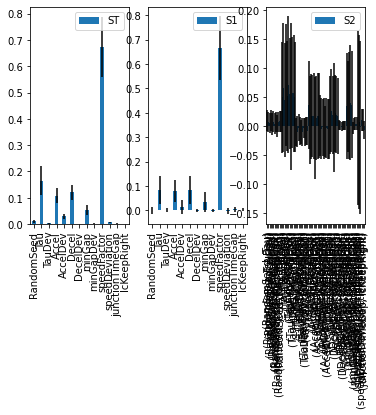

In [42]:
Si.plot()


## Plotting with Plotly

In [47]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

### Ternary Plotting

In [48]:
fig = px.scatter_ternary(results_df, a=min_max_scaler(results_df["speedFactor"]), b=min_max_scaler(results_df["Tau"]), c=min_max_scaler(results_df["Accel"]), color="Fuel_Gal", size_max=15,
    )
fig.show()

In [ ]:
import plotly.graph_objects as go

# import plotly.


In [ ]:
names = ["Tau", "Delta", "Accel", "Speed Factor"]


In [ ]:
fig = go.Figure()


fig.add_trace(
    go.Bar(
        x=sensitivity_df.index,
        y=sensitivity_df["S1"],
        name="First Order",
        error_y=dict(type="data", array=sensitivity_df["S1_conf"].values),
    )
)
fig.add_trace(
    go.Bar(
        x=sensitivity_df.index,
        y=sensitivity_df["ST"] - sensitivity_df["S1"],
        name="Total",
        error_y=dict(type="data", array=sensitivity_df["ST_conf"].values),
    )
)

fig.update_layout(
    barmode="stack", template="ggplot2", height=600, width=1000, font_size=18
)

fig.show()


### Top Param

### The mean line

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
# param_name = sensitivity_df['ST'].sort_values(ascending=False).index[0]
param_name = "Accel"
y_val = "Fuel_Gal"


In [ ]:
model = LinearRegression().fit(
    results_df[param_name].values.reshape((-1, 1)), results_df[y_val].values
)
fit_fuel = model.predict(results_df[param_name].unique().reshape((-1, 1)))

mean_df = results_df[[y_val, param_name]].groupby(param_name).mean()


In [ ]:
r_sq = model.score(
    results_df[param_name].values.reshape((-1, 1)), results_df[y_val].values
)
print("coefficient of determination:", r_sq)


coefficient of determination: 0.17058721723719794


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=results_df[param_name].unique(),
        y=fit_fuel,
        mode="lines",
        line_width=4,
        name="Linear Trend",
    ),
)

fig.add_trace(
    go.Scatter(
        x=mean_df.index, y=mean_df[y_val], mode="lines", line_width=4, name="Mean"
    )
)

fig.add_trace(
    go.Scatter(
        x=results_df[param_name],
        y=results_df[y_val],
        mode="markers",
        customdata=results_df.index,
        hovertemplate="sample num:%{customdata:.0f}<br>val:%{y:.3f}",
    )
)

fig.update_layout(yaxis=dict(title=y_val), xaxis=dict(title=param_name))

fig.update_layout(
    barmode="stack", template="ggplot2", height=600, width=1200, font_size=18
)
# fig.update_layout(hovermode="x unified")

fig.show()


In [ ]:
var = "Tau"
y_var = "cal_score"

fig = go.Figure()
fig.add_trace(go.Histogram2d(
    x=results_df[columns.Tau],
    y=results_df[columns.Accel],
    z=results_df[columns.cal_score],
    histfunc="avg",
    xbins_size=.5,
    ybins_size=.5,
)) 
# (x=results_df[var], y=results_df[y_var], mode="markers"))
fig.update_layout(yaxis=dict(title="Accel"), xaxis=dict(title="Tau"))
fig.show()


In [ ]:

fig = go.Figure()
fig.add_trace(go.Histogram2d(
    x=results_df[columns.Accel],
    y=results_df[columns.speedFactor],
    z=results_df["Fuel_Gal"],
    histfunc="avg",
    xbins_size=.5,
    ybins_size=.1,
)) 
# (x=results_df[var], y=results_df[y_var], mode="markers"))
fig.update_layout(yaxis=dict(title="Speed Factor"), xaxis=dict(title="Accel"))
fig.show()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['CarFollowingParameters_delta'], y=results_df['Fuel_Gal'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Delta')
#                  )
# fig.show()


In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['PersonalCar_accel'], y=results_df['Fuel_Gal'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Personal Car Accel [m/s^2]')
#                  )
# fig.show()


In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_tau'], y=results_df['Fuel_Gal'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Tau [s]')
#                  )
# fig.show()


In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_delta'], y=results_df['Fuel_Gal'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Delta')
#                  )
# fig.show()


In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=results_df['Class8Truck_accel'], y=results_df['Fuel_Gal'], mode='markers'))
# fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
#                   xaxis=dict(title='Class8Truck Accel [m/s^2]')
#                  )
# fig.show()
